In [1]:
# ── 0) Imports & Config ───────────────────────────────────────────────────────
import os, re, hashlib, glob
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

pd.set_option("display.max_columns", 120)

DATA_DIR = Path.home() / "Downloads" / "สถิติรายปีการเกิดอุทกภัย"  # <- ปรับได้
OUT_CLEAN_DIR = Path("data_clean")
OUT_DIR = Path("outputs")
OUT_CLEAN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ── 1) Column mapping (TH/EN) → unified schema ───────────────────────────────
COLMAP = {
    # Dates / Event meta
    "ประเภทภัย": "hazard_type", "Incident Name": "incident_name",
    "วันที่เกิดภัย": "disaster_date", "Disaster Date": "disaster_date",
    "วันที่ประกาศยุติภัย": "end_disaster_date", "End Disaster Date": "end_disaster_date",
    "วันที่ประกาศเขตช่วยเหลือ": "relief_declared_date", "Relief Declared Date": "relief_declared_date",
    "วันที่ประกาศพื้นที่ประสบภัย": "disaster_area_date", "Disaster Area Date": "disaster_area_date",
    "วันที่ประกาศอื่นๆ": "other_announce_date", "Other Announce Date": "other_announce_date",

    # Geo codes / names
    "รหัสจังหวัด": "province_code", "Province Code": "province_code",
    "จังหวัด": "province", "Province": "province",
    "รหัสอำเภอ": "district_code", "District Code": "district_code",
    "อำเภอ": "district", "District": "district",
    "รหัสตำบล": "subdistrict_code", "Subdistrict Code": "subdistrict_code",
    "ตำบล": "subdistrict", "Subdistrict": "subdistrict",
    "หมู่ที่": "moo", "Moo": "moo",
    "รหัสเทศบาล": "municipal_code", "Municipal Code": "municipal_code",
    "เทศบาล": "municipality", "Municipality": "municipality",
    "ชุมชน": "community", "Community": "community",
    "รหัสหมู่บ้าน": "village_code", "Village Code": "village_code",

    # Admin / cause
    "ชื่อศูนย์เขต": "zone_center_name", "Zone Center Name": "zone_center_name",
    "ลักษณะ/สาเหตุ": "cause", "Cause": "cause",

    # People & Household
    'ผู้ได้รับผลกระทบ\n(คน)': 'affected_people', "Affected People": "affected_people",
    'ผู้ได้รับผลกระทบ\n(ครัวเรือน)': 'affected_households', "Affected Households": "affected_households",
    'ผู้อพยพ\n(คน)': 'evacuated_people', "Evacuated People": "evacuated_people",
    'ผู้อพยพ\n(ครัวเรือน)': 'evacuated_households', "Evacuated Households": "evacuated_households",
    'ผู้เสียชีวิต\n(คน)': 'deaths', "Deaths": "deaths",
    'สูญหาย\n(คน)': 'missing', "Missing": "missing",
    'ผู้บาดเจ็บ\n(คน)': 'injured', "Injured": "injured",

    # Damages (units follow raw spec)
    'ด้านที่อยู่อาศัย\n(หลัง/แห่ง)': 'damage_housing', "Housing Damage": "damage_housing",
    'ด้านธุรกิจ\n(แห่ง)': 'damage_business', "Business Damage": "damage_business",
    'ด้านการเกษตร\n(ไร่)': 'damage_agriculture', "Agriculture Damage": "damage_agriculture",
    'ด้านปศุสัตว์\n(ตัว)': 'damage_livestock', "Livestock Damage": "damage_livestock",
    'ด้านประมง\n(บ่อ/กระชัง/ไร่)': 'damage_fishing', "Fishing Damage": "damage_fishing",
    'ด้านคมนาคม\n(แห่ง)': 'damage_transport', "Transport Damage": "damage_transport",
    'ด้านสาธารณสุข\n(แห่ง)': 'damage_health', "Health Damage": "damage_health",
    'ด้านศาสนาวัฒนธรรม\n(แห่ง)': 'damage_culture', "Culture Damage": "damage_culture",
    'ด้านสถานศึกษา/กีฬา\n(แห่ง)': 'damage_education_sports', "Education/Sports": "damage_education_sports",
    'ด้านสาธารณูปโภค\n(แห่ง)': 'damage_utilities', "Utilities Damage": "damage_utilities",
    'ด้านสถานที่ราชการ\n(แห่ง)': 'damage_gov_locations', "Govt. Locations Damage": "damage_gov_locations",
    'ด้านสาธารณประโยชน์อื่น\n(แห่ง)': 'damage_other_public', "Other Public Benefits": "damage_other_public",
    'ด้านทรัพย์สินราชการ/เอกชน\n(หน่วย)': 'damage_gov_property', "Govt Property Damage": "damage_gov_property",
}

UNIFIED_ORDER = [
    "hazard_type","incident_name","disaster_date","end_disaster_date",
    "relief_declared_date","disaster_area_date","other_announce_date",
    "province_code","province","district_code","district","subdistrict_code","subdistrict",
    "village_code","municipal_code","municipality","community","moo","zone_center_name","cause",
    "affected_people","affected_households","evacuated_people","evacuated_households",
    "deaths","missing","injured",
    "damage_housing","damage_business","damage_agriculture","damage_livestock","damage_fishing",
    "damage_transport","damage_health","damage_culture","damage_education_sports","damage_utilities",
    "damage_gov_locations","damage_other_public","damage_gov_property"
]

# ── 2) Helpers ────────────────────────────────────────────────────────────────
def thai_to_gregorian_date(s):
    """Parse dd/mm/yyyy (TH or EN). If year > 2400, convert BE→AD by -543."""
    if pd.isna(s): return pd.NaT
    s = str(s).strip()
    # Try common formats
    for fmt in ("%d/%m/%Y", "%d-%m-%Y", "%Y-%m-%d", "%d/%m/%y"):
        try:
            dt = datetime.strptime(s, fmt)
            y = dt.year
            if y > 2400:  # Buddhist year
                dt = dt.replace(year=y - 543)
            return pd.Timestamp(dt)
        except ValueError:
            continue
    # Try Excel serial?
    try:
        v = float(s)
        # pandas handles excel serial with origin
        return pd.to_datetime(v, unit='D', origin='1899-12-30', errors='coerce')
    except:
        return pd.NaT

def to_num(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s in ("", "-", "NA", "N/A", "null", "undefined"): return np.nan
    s = s.replace(",", "")
    try:
        return float(s)
    except:
        return np.nan

def zero_pad_code(x, minlen=0):
    if pd.isna(x): return np.nan
    s = re.sub(r"\D", "", str(x))
    if not s: return np.nan
    if minlen>0: s = s.zfill(minlen)
    return s

def unify_columns(df):
    # map columns
    renamed = {}
    for c in df.columns:
        c2 = c.strip()
        if c2 in COLMAP:
            renamed[c] = COLMAP[c2]
    df = df.rename(columns=renamed)
    # ensure all unified columns exist
    for c in UNIFIED_ORDER:
        if c not in df.columns:
            df[c] = np.nan
    # reorder
    df = df[UNIFIED_ORDER]
    return df

def normalize_frame(df):
    # dates
    for dc in ["disaster_date","end_disaster_date","relief_declared_date","disaster_area_date","other_announce_date"]:
        df[dc] = df[dc].apply(thai_to_gregorian_date)

    # geo codes (pad by typical length if present)
    df["province_code"]   = df["province_code"].apply(lambda x: zero_pad_code(x))
    df["district_code"]   = df["district_code"].apply(lambda x: zero_pad_code(x))
    df["subdistrict_code"]= df["subdistrict_code"].apply(lambda x: zero_pad_code(x))
    df["village_code"]    = df["village_code"].apply(lambda x: zero_pad_code(x))

    # numeric impacts
    num_cols = [
        "affected_people","affected_households","evacuated_people","evacuated_households",
        "deaths","missing","injured",
        "damage_housing","damage_business","damage_agriculture","damage_livestock","damage_fishing",
        "damage_transport","damage_health","damage_culture","damage_education_sports","damage_utilities",
        "damage_gov_locations","damage_other_public","damage_gov_property"
    ]
    for c in num_cols:
        df[c] = df[c].apply(to_num)

    # derived
    df["year"] = df["disaster_date"].dt.year
    df["month"] = df["disaster_date"].dt.month
    df["duration_days"] = (df["end_disaster_date"] - df["disaster_date"]).dt.days + 1
    df.loc[df["duration_days"].isna() | (df["duration_days"]<=0), "duration_days"] = 1

    # incident id for dedupe (stable within dataset)
    def _mk_id(row):
        key = "|".join([
            str(row.get("disaster_date", ""))[:10],
            str(row.get("province_code","")),
            str(row.get("district_code","")),
            str(row.get("subdistrict_code","")),
            str(row.get("incident_name",""))[:80],
            str(row.get("cause",""))[:80],
        ])
        return hashlib.md5(key.encode("utf-8")).hexdigest()
    df["incident_id"] = df.apply(_mk_id, axis=1)
    df = df.drop_duplicates(subset=["incident_id"])
    return df

def load_all_files(data_dir: Path):
    files = []
    files += glob.glob(str(data_dir / "*.csv"))
    files += glob.glob(str(data_dir / "*.xlsx"))
    frames = []
    for f in files:
        try:
            if f.lower().endswith(".csv"):
                df = pd.read_csv(f, encoding="utf-8", dtype=str)
            else:
                df = pd.read_excel(f, dtype=str)
            df = unify_columns(df)
            df = normalize_frame(df)
            df["source_file"] = os.path.basename(f)
            frames.append(df)
            print(f"✅ loaded & normalized: {os.path.basename(f)}  rows={len(df)}")
        except Exception as e:
            print(f"⚠️ skip {os.path.basename(f)}: {e}")
    if not frames:
        raise RuntimeError("No files loaded. Check DATA_DIR path or filenames.")
    all_df = pd.concat(frames, ignore_index=True)
    return all_df

# ── 3) Load & save cleaned parquet ───────────────────────────────────────────
all_df = load_all_files(DATA_DIR)
all_df.to_parquet(OUT_CLEAN_DIR / "flood_10y_clean.parquet", index=False)
all_df.sample(5)

✅ loaded & normalized: gd027_flood_2566_final.csv  rows=3686
✅ loaded & normalized: gd027_flood_2565_final.csv  rows=1
✅ loaded & normalized: gd027_flood_2563_final.csv  rows=1
✅ loaded & normalized: gd027_flood_2564_final.csv  rows=1
✅ loaded & normalized: gd027_flood_stat2562_final.csv  rows=1
✅ loaded & normalized: gd027_flood_stat2566_final.xlsx  rows=1
✅ loaded & normalized: gd027_flood_stat2562_final.xlsx  rows=1


,hazard_type,incident_name,disaster_date,end_disaster_date,relief_declared_date,disaster_area_date,other_announce_date,province_code,province,district_code,district,subdistrict_code,subdistrict,village_code,municipal_code,municipality,community,moo,zone_center_name,cause,affected_people,affected_households,evacuated_people,evacuated_households,deaths,missing,injured,damage_housing,damage_business,damage_agriculture,damage_livestock,damage_fishing,damage_transport,damage_health,damage_culture,damage_education_sports,damage_utilities,damage_gov_locations,damage_other_public,damage_gov_property,year,month,duration_days,incident_id,source_file
3538,NaN,อุทกภัย,2023-09-17,2023-09-29,2023-09-29,2023-09-29,NaT,53,อุตรดิตถ์,5305,ฟากท่า,530503,บ้านเสี้ยว,53050301,,,,1,ศปภ. เขต 9 พิษณุโลก,น้ำล้นตลิ่ง,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,9.0,13.0,3ab8b2396e0ac1a00b831b68fc74e094,gd027_flood_2566_final.csv
3398,NaN,อุทกภัย,2023-07-25,2023-09-11,2023-09-11,2023-09-11,NaT,41,อุดรธานี,4104,กุมภวาปี,410414,ท่าลี่,41041410,,,,10,ศปภ. เขต 14 อุดรธานี,"น้ำท่วมขัง , น้ำป่าไหลหลาก/น้ำท่วมฉับพลัน",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,7.0,49.0,72210ac981cabebaeb2aedb1eecefed2,gd027_flood_2566_final.csv
986,NaN,อุทกภัย,2023-10-03,2023-10-26,NaT,2023-10-16,NaT,63,ตาก,6309,วังเจ้า,630903,ประดาง,63090303,,,,3,ศปภ. เขต 8 กำแพงเพชร,น้ำป่าไหลหลาก/น้ำท่วมฉับพลัน,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,10.0,24.0,4792b3f9ec3105fc335dfb2a01a46735,gd027_flood_2566_final.csv
2529,NaN,อุทกภัย,2023-09-29,NaT,NaT,2023-10-12,NaT,52,ลำปาง,5201,เมืองลำปาง,520116,บ่อแฮ้ว,52011612,,,,12,ศปภ. เขต 10 ลำปาง,น้ำป่าไหลหลาก/น้ำท่วมฉับพลัน,48.0,16.0,NaN,0.0,0.0,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,9.0,1.0,e4dbe4d6e0354180f82a9a32bd4fe853,gd027_flood_2566_final.csv
2984,NaN,อุทกภัย,2023-09-17,2024-01-11,2023-09-22,2023-09-22,NaT,64,สุโขทัย,6406,ศรีสำโรง,640610,ทับผึ้ง,64061002,,,,2,ศปภ. เขต 9 พิษณุโลก,น้ำท่วมขัง,556.0,276.0,NaN,0.0,0.0,0.0,0.0,276.0,NaN,4295.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2023.0,9.0,117.0,19b08a3cc5e2176383ac9041370c52bb,gd027_flood_2566_final.csv


In [3]:
pip install chardet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import csv
import chardet  # ถ้าไม่มี ให้ `pip install chardet` หรือคอมเมนต์บล็อกตรวจ encoding ออก
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

HEADER_TOKENS = {
    "th": ["ประเภทภัย","วันที่เกิดภัย","รหัสจังหวัด","จังหวัด","รหัสอำเภอ","อำเภอ","รหัสตำบล","ตำบล","ชื่อศูนย์เขต","ลักษณะ/สาเหตุ"],
    "en": ["Incident Name","Disaster Date","Province Code","Province","District Code","District","Subdistrict Code","Subdistrict","Zone Center Name","Cause"],
}
ALL_HEADER_KEYS = set(sum(HEADER_TOKENS.values(), []))

def detect_encoding(path, nbytes=20000):
    with open(path, "rb") as f:
        raw = f.read(nbytes)
    try:
        return chardet.detect(raw)["encoding"] or "utf-8"
    except:
        return "utf-8"

def find_header_row(df_like):
    """รับ DataFrame ชั่วคราวจาก read_csv(skiprows=k, header=None)
       แล้วคืน index แถวที่น่าจะเป็น header ที่แท้จริง (หรือ 0 ถ้าไม่เจอ)"""
    best_idx, best_hit = 0, 0
    for i in range(min(10, len(df_like))):
        row_vals = set(str(x).strip() for x in df_like.iloc[i].tolist())
        hits = len(row_vals & ALL_HEADER_KEYS)
        if hits > best_hit:
            best_idx, best_hit = i, hits
    return best_idx

def smart_read_csv(path):
    # 1) ตรวจ encoding + delimiter
    enc = detect_encoding(path)
    with open(path, "r", encoding=enc, errors="ignore") as f:
        sample = f.read(4096)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=",;|\t")
        delim = dialect.delimiter
    except:
        # เดาว่าเป็น comma ก่อน
        delim = ","

    # 2) อ่านแบบไร้ header เพื่อตรวจหา header row
    tmp = pd.read_csv(path, encoding=enc, sep=delim, header=None, dtype=str, on_bad_lines="skip")
    if tmp.shape[1] == 1:
        # กรณีเจอไฟล์คั่นผิด ลองกลับ delimiter
        alt = ";" if delim != ";" else ","
        tmp2 = pd.read_csv(path, encoding=enc, sep=alt, header=None, dtype=str, on_bad_lines="skip")
        if tmp2.shape[1] > tmp.shape[1]:
            tmp, delim = tmp2, alt

    hdr_idx = find_header_row(tmp)
    df = pd.read_csv(path, encoding=enc, sep=delim, header=hdr_idx, dtype=str, on_bad_lines="skip")
    # ลบแถวก่อน header ออก
    if hdr_idx > 0:
        df = df.iloc[(0):].reset_index(drop=True)
    return df

def smart_read_excel(path):
    x = pd.ExcelFile(path)
    # เลือกชีตที่ “เข้าท่าสุด”: มีจำนวนแถวเยอะ + มีหัวตารางที่คุ้น
    best_name, best_score = None, -1
    for name in x.sheet_names:
        df = pd.read_excel(path, sheet_name=name, header=None, dtype=str)
        hdr_idx = find_header_row(df)
        row_vals = set(str(v).strip() for v in df.iloc[hdr_idx].tolist())
        hits = len(row_vals & ALL_HEADER_KEYS)
        score = hits * 1000 + len(df)  # ให้ weight กับการแมตช์คีย์หัวตารางก่อน
        if score > best_score:
            best_name, best_score = name, score
    # อ่านชีตที่ได้ พร้อมตัด header แถวที่ถูกต้อง
    df0 = pd.read_excel(path, sheet_name=best_name, header=None, dtype=str)
    hdr_idx = find_header_row(df0)
    df = pd.read_excel(path, sheet_name=best_name, header=hdr_idx, dtype=str)
    return df

def load_all_files(data_dir: Path):
    files = []
    files += glob.glob(str(data_dir / "*.csv"))
    files += glob.glob(str(data_dir / "*.xlsx"))
    frames = []
    for f in files:
        base = os.path.basename(f)
        try:
            # แยกกลุ่มไฟล์สรุป (รวมสถิติ) ออก ไม่ปนกับเหตุการณ์ระดับแถว
            if "stat" in base.lower():
                print(f"ℹ️ skip summary/stat file: {base}")
                continue

            if f.lower().endswith(".csv"):
                raw = smart_read_csv(f)
            else:
                raw = smart_read_excel(f)

            # map + normalize ตามฟังก์ชันเดิม
            df = unify_columns(raw)
            df = normalize_frame(df)

            # แก้กรณี hazard_type หลุดไปอยู่ incident_name (เช่น “อุทกภัย”)
            def move_hazard(row):
                if pd.isna(row["hazard_type"]) and str(row["incident_name"]).strip() in ["อุทกภัย","น้ำท่วม","อุทกภัย/น้ำท่วม"]:
                    row["hazard_type"] = str(row["incident_name"]).strip()
                    row["incident_name"] = np.nan
                return row
            df = df.apply(move_hazard, axis=1)

            # sanity: ถ้า year missing ให้ลองเดาจากชื่อไฟล์ (เช่น 2566 → 2023)
            if df["year"].isna().all():
                m = re.search(r"(25\d{2}|20\d{2})", base)
                if m:
                    y = int(m.group(1))
                    if y > 2400: y -= 543
                    df["year"] = y

            df["source_file"] = base
            frames.append(df)
            print(f"✅ loaded & normalized: {base}  rows={len(df)}  (non-null year % = {df['year'].notna().mean():.2%})")
        except Exception as e:
            print(f"⚠️ skip {base}: {e}")

    if not frames:
        raise RuntimeError("No event-level files loaded. Check DATA_DIR or file format.")
    return pd.concat(frames, ignore_index=True)

In [5]:
print("rows =", len(all_df), "years =", sorted(all_df['year'].dropna().unique().tolist()))
all_df.groupby("source_file")["incident_id"].nunique().sort_values(ascending=False).head(20)

rows = 3692 years = [2023.0]


source_file
gd027_flood_2566_final.csv         3686
gd027_flood_2563_final.csv            1
gd027_flood_2564_final.csv            1
gd027_flood_2565_final.csv            1
gd027_flood_stat2562_final.csv        1
gd027_flood_stat2562_final.xlsx       1
gd027_flood_stat2566_final.xlsx       1
Name: incident_id, dtype: int64

In [6]:
import csv, warnings, re, glob, os
import pandas as pd
import numpy as np
from pathlib import Path

warnings.filterwarnings("ignore", category=UserWarning)

HEADER_TOKENS = {
    "th": ["ประเภทภัย","วันที่เกิดภัย","รหัสจังหวัด","จังหวัด","รหัสอำเภอ","อำเภอ","รหัสตำบล","ตำบล","ชื่อศูนย์เขต","ลักษณะ/สาเหตุ"],
    "en": ["Incident Name","Disaster Date","Province Code","Province","District Code","District","Subdistrict Code","Subdistrict","Zone Center Name","Cause"],
}
ALL_HEADER_KEYS = set(sum(HEADER_TOKENS.values(), []))

def _find_header_row(df_like, max_rows=30):
    best_idx, best_hit = 0, -1
    n = min(max_rows, len(df_like))
    for i in range(n):
        row_vals = set(str(x).strip() for x in df_like.iloc[i].tolist())
        hits = len(row_vals & ALL_HEADER_KEYS)
        if hits > best_hit:
            best_idx, best_hit = i, hits
    return best_idx, best_hit

def _score_df(df):
    # ให้คะแนนตามจำนวนคอลัมน์ + การแมตช์หัวตาราง
    hdr_idx, hits = _find_header_row(df, max_rows=30)
    ncols = df.shape[1]
    nrows = df.shape[0]
    return hits*100000 + ncols*100 + min(nrows, 200)  # เน้น hits ก่อน แล้วดูคอลัมน์

def smart_read_csv(path: str):
    # ลองหลาย encoding × delimiter × engine × header-scan
    encodings = ["utf-8-sig","utf-8","cp874","tis-620","iso-8859-11","windows-874","latin1"]
    delims    = [",",";","\t","|"]
    engines   = ["c","python"]  # sep=None รองรับเฉพาะ engine='python'
    best = None
    best_conf = None

    # 0) quick try: sep=None (infer) + engine='python'
    try:
        df0 = pd.read_csv(path, sep=None, engine="python", header=None, dtype=str, on_bad_lines="skip")
        score0 = _score_df(df0)
        best = df0; best_conf = ("infer", None, "python", score0)
    except Exception:
        pass

    for enc in encodings:
        for eng in engines:
            # 1) no header, fixed delimiter
            for sep in delims:
                try:
                    tmp = pd.read_csv(path, encoding=enc, sep=sep, engine=eng, header=None, dtype=str, on_bad_lines="skip")
                    sc = _score_df(tmp)
                    if (best is None) or (sc > best_conf[3]):
                        best, best_conf = tmp, (sep, enc, eng, sc)
                except Exception:
                    continue

    if best is None:
        raise RuntimeError(f"Cannot parse CSV: {path}")

    hdr_idx, _ = _find_header_row(best, max_rows=30)
    sep, enc, eng, _ = best_conf
    # อ่านใหม่ด้วย header ที่เจอ
    if sep == "infer":
        df = pd.read_csv(path, sep=None, engine="python", header=hdr_idx, dtype=str, on_bad_lines="skip")
        final_conf = f"sep=INFER, enc=auto, engine=python, header_row={hdr_idx}"
    else:
        df = pd.read_csv(path, encoding=enc, sep=sep, engine=eng, header=hdr_idx, dtype=str, on_bad_lines="skip")
        final_conf = f"sep={repr(sep)}, enc={enc}, engine={eng}, header_row={hdr_idx}"
    print(f"🔎 CSV chosen: {os.path.basename(path)}  [{final_conf}]  shape={df.shape}")
    return df

def smart_read_excel(path: str):
    x = pd.ExcelFile(path)
    best_name, best_df, best_score = None, None, -1
    for name in x.sheet_names:
        df0 = pd.read_excel(path, sheet_name=name, header=None, dtype=str)
        sc = _score_df(df0)
        if sc > best_score:
            best_name, best_df, best_score = name, df0, sc
    hdr_idx, _ = _find_header_row(best_df, max_rows=30)
    df = pd.read_excel(path, sheet_name=best_name, header=hdr_idx, dtype=str)
    print(f"🔎 XLSX chosen: {os.path.basename(path)}  [sheet={best_name}, header_row={hdr_idx}]  shape={df.shape}")
    return df

In [7]:
def load_all_files(data_dir: Path):
    files = glob.glob(str(data_dir / "*.csv")) + glob.glob(str(data_dir / "*.xlsx"))
    frames = []
    for f in files:
        base = os.path.basename(f)
        try:
            # ข้ามไฟล์สรุป (มีคำว่า stat)
            if re.search(r"stat", base, flags=re.I):
                print(f"ℹ️ skip summary/stat file: {base}")
                continue

            raw = smart_read_excel(f) if f.lower().endswith(".xlsx") else smart_read_csv(f)

            # map + normalize (ใช้ฟังก์ชันจากโน้ตเดิมของคุณ)
            df = unify_columns(raw)
            df = normalize_frame(df)

            # ซ่อม hazard_type จาก incident_name/cause ถ้าว่าง
            def move_hazard(row):
                name = str(row["incident_name"]).strip() if pd.notna(row["incident_name"]) else ""
                cause = str(row["cause"]).strip() if pd.notna(row["cause"]) else ""
                if pd.isna(row["hazard_type"]):
                    if name in ("อุทกภัย","น้ำท่วม","อุทกภัย/น้ำท่วม"): row["hazard_type"] = "อุทกภัย"
                    elif "น้ำท่วม" in cause or "น้ำป่า" in cause or "ล้นตลิ่ง" in cause: row["hazard_type"] = "อุทกภัย"
                # ถ้า incident_name เป็นคำทั่วไปของ hazard ให้ย้ายไป hazard แล้วเคลียร์ incident
                if name in ("อุทกภัย","น้ำท่วม","อุทกภัย/น้ำท่วม"):
                    row["incident_name"] = np.nan
                return row
            df = df.apply(move_hazard, axis=1)

            # เติม year จากชื่อไฟล์หากยังหาย (256x → 20xx)
            if df["year"].isna().all():
                m = re.search(r"(25\d{2}|20\d{2})", base)
                if m:
                    y = int(m.group(1))
                    if y > 2400: y -= 543
                    df["year"] = y

            df["source_file"] = base
            frames.append(df)
            print(f"✅ loaded & normalized: {base}  rows={len(df)}  years(non-null)={sorted(df['year'].dropna().unique())}")
        except Exception as e:
            print(f"⚠️ skip {base}: {e}")

    if not frames:
        raise RuntimeError("No event-level files loaded.")
    return pd.concat(frames, ignore_index=True)

In [22]:
# 🚰 Flood loader — 1 cell (with filename-year fallback + date-column ranking)
import pandas as pd, numpy as np, re, hashlib, glob, os, warnings
from datetime import datetime
from pathlib import Path
warnings.filterwarnings("ignore", category=UserWarning)

DATA_DIR = Path.home() / "Downloads" / "สถิติรายปีการเกิดอุทกภัย"

THAI_DIGITS = str.maketrans("๐๑๒๓๔๕๖๗๘๙", "0123456789")
def norm_str(s): return "" if pd.isna(s) else str(s).strip()
def to_arabic(s): return norm_str(s).translate(THAI_DIGITS)

# ── รองรับเดือนภาษาไทย ──
TH_MONTHS = {
    # แบบย่อ
    "ม.ค.":1, "ก.พ.":2, "มี.ค.":3, "เม.ย.":4, "พ.ค.":5, "มิ.ย.":6,
    "ก.ค.":7, "ส.ค.":8, "ก.ย.":9, "ต.ค.":10, "พ.ย.":11, "ธ.ค.":12,
    # แบบเต็ม
    "มกราคม":1, "กุมภาพันธ์":2, "มีนาคม":3, "เมษายน":4, "พฤษภาคม":5, "มิถุนายน":6,
    "กรกฎาคม":7, "สิงหาคม":8, "กันยายน":9, "ตุลาคม":10, "พฤศจิกายน":11, "ธันวาคม":12,
}

def thai_to_date(x):
    if pd.isna(x): return pd.NaT
    t = to_arabic(x).strip()
    if t == "" or t.lower() in {"na","n/a","null","none","-"}: return pd.NaT

    # ตัดเวลาออก (กรณีมี "00:00:00")
    t_full = t
    t = re.split(r"\s+", t)[0]

    # Excel serial
    if re.fullmatch(r"\d{5,}", t):
        try:
            return pd.to_datetime(float(t), unit="D", origin="1899-12-30", errors="coerce")
        except:
            pass

    # 1) dd-ต.ค.-63 / dd-ต.ค.-2563
    m = re.fullmatch(r"(\d{1,2})[-/](ม\.ค\.|ก\.พ\.|มี\.ค\.|เม\.ย\.|พ\.ค\.|มิ\.ย\.|ก\.ค\.|ส\.ค\.|ก\.ย\.|ต\.ค\.|พ\.ย\.|ธ\.ค\.)[-/](\d{2,4})", t)
    if m:
        d, mth, y = m.groups()
        d = int(d); month = TH_MONTHS[mth]; y = int(y)
        yyyy = (2500+y)-543 if y<100 and y>=60 else (2000+y if y<100 else (y-543 if y>2400 else y))
        try: return pd.Timestamp(year=yyyy, month=month, day=d)
        except: return pd.NaT

    # 2) dd <เดือนไทยเต็ม> yyyy  e.g., 6 พฤศจิกายน 2564
    m = re.fullmatch(r"(\d{1,2})\s+(มกราคม|กุมภาพันธ์|มีนาคม|เมษายน|พฤษภาคม|มิถุนายน|กรกฎาคม|สิงหาคม|กันยายน|ตุลาคม|พฤศจิกายน|ธันวาคม)\s+(\d{2,4})", t_full)
    if m:
        d, mth, y = m.groups()
        d = int(d); month = TH_MONTHS[mth]; y = int(y)
        yyyy = (2500+y)-543 if y<100 and y>=60 else (2000+y if y<100 else (y-543 if y>2400 else y))
        try: return pd.Timestamp(year=yyyy, month=month, day=d)
        except: return pd.NaT

    # 3) dd/mm/yy หรือ dd-mm-yy (เลขล้วน)
    t2 = re.sub(r"[.]", "/", t)
    m = re.fullmatch(r"(\d{1,2})[/-](\d{1,2})[/-](\d{2})", t2)
    if m:
        d, M, yy = map(int, m.groups())
        yyyy = (2500+yy)-543 if yy>=60 else 2000+yy
        try: return pd.Timestamp(year=yyyy, month=M, day=d)
        except: return pd.NaT

    # 4) dd/mm/YYYY หรือ dd-mm-YYYY
    m = re.fullmatch(r"(\d{1,2})[/-](\d{1,2})[/-](\d{4})", t2)
    if m:
        d, M, yyyy = map(int, m.groups())
        if yyyy>2400: yyyy -= 543
        try: return pd.Timestamp(year=yyyy, month=M, day=d)
        except: return pd.NaT

    # 5) ISO/ทั่วไป (ให้ pandas ช่วย)
    dt = pd.to_datetime(t_full, dayfirst=True, errors="coerce")
    if pd.isna(dt): return pd.NaT
    if dt.year>2400: dt = dt.replace(year=dt.year-543)
    if dt.year>2100:
        tail2 = re.search(r"[/-](\d{2})(?:\D|$)", t2)
        if tail2:
            yy = int(tail2.group(1))
            yyyy = (2500+yy)-543 if yy>=60 else 2000+yy
            dt = dt.replace(year=yyyy)
    return pd.Timestamp(dt)


# กำหนดกรอบปีที่ยอมรับ (ปรับได้ตามชุดข้อมูลจริง)
MIN_Y, MAX_Y = 2015, 2025

def _infer_year_from_tail_2digits(raw: str) -> int | None:
    """เดาปีจากเลขสองหลักท้ายของสตริง เช่น '...-63' -> 2020, '.../21' -> 2021"""
    s = to_arabic(raw)
    m = re.search(r"(\d{2})(?!\d)\s*$", s)
    if not m: 
        return None
    yy = int(m.group(1))
    # 63 -> 2563 - 543 = 2020, 21 -> 2021
    return (2500 + yy) - 543 if yy >= 60 else 2000 + yy

def repair_year_from_text(ts: pd.Timestamp, raw: str, file_year: int | None = None) -> pd.Timestamp:
    """
    ซ่อมปีผิดปกติอย่างปลอดภัย:
    - BE (พ.ศ.) -> AD (ค.ศ.)
    - ปี >2100 -> ลองเดาจากเลขสองหลักท้าย
    - ถ้าซ่อมแล้วยังหลุดกรอบ -> ใช้ file_year หรือคืน NaT
    - ป้องกัน OutOfBoundsDatetime ด้วย guard + try/except
    """
    if pd.isna(ts):
        return ts

    y = int(ts.year)

    # เคสเป็น พ.ศ. (กว้าง ๆ)
    if 2060 <= y <= 2600:
        cand = y - 543
        if MIN_Y <= cand <= MAX_Y:
            try:
                return ts.replace(year=cand)
            except Exception:
                return pd.NaT
        # ถ้าหลังลบ 543 ยังหลุดกรอบ ลองเลขสองหลักท้าย
        tail = _infer_year_from_tail_2digits(raw)
        if tail and (MIN_Y <= tail <= MAX_Y):
            try:
                return ts.replace(year=tail)
            except Exception:
                return pd.NaT
        # fallback ตามปีไฟล์ถ้าอยู่ในกรอบ
        if file_year and (MIN_Y <= file_year <= MAX_Y):
            try:
                return pd.Timestamp(year=file_year, month=ts.month, day=ts.day)
            except Exception:
                return pd.Timestamp(year=file_year, month=7, day=1)
        return pd.NaT

    # ปีเกิน 2100 ที่ไม่ใช่ พ.ศ. → เดาจากเลขสองหลักท้าย
    if y > 2100:
        tail = _infer_year_from_tail_2digits(raw)
        if tail and (MIN_Y <= tail <= MAX_Y):
            try:
                return ts.replace(year=tail)
            except Exception:
                return pd.NaT
        if file_year and (MIN_Y <= file_year <= MAX_Y):
            try:
                return pd.Timestamp(year=file_year, month=ts.month, day=ts.day)
            except Exception:
                return pd.Timestamp(year=file_year, month=7, day=1)
        return pd.NaT

    # ปีต่ำกว่า MIN_Y หรือสูงกว่า MAX_Y → พยายามซ่อม, ไม่ได้ก็ NaT
    if not (MIN_Y <= y <= MAX_Y):
        tail = _infer_year_from_tail_2digits(raw)
        if tail and (MIN_Y <= tail <= MAX_Y):
            try:
                return ts.replace(year=tail)
            except Exception:
                return pd.NaT
        if file_year and (MIN_Y <= file_year <= MAX_Y):
            try:
                return pd.Timestamp(year=file_year, month=ts.month, day=ts.day)
            except Exception:
                return pd.Timestamp(year=file_year, month=7, day=1)
        return pd.NaT

    # ปีอยู่ในกรอบอยู่แล้ว
    return ts



def to_num(x):
    s = to_arabic(x)
    if s=="" or s.lower() in {"na","n/a","null","none","-"}: return np.nan
    try: return float(s.replace(",","").replace(" ",""))
    except: return np.nan

def only_digits(x):
    s = to_arabic(x)
    s = re.sub(r"\D","", s)
    return s if s else np.nan

def canon_header(s):
    s = to_arabic(s)
    s = re.sub(r"[\s\n\r\t]+","", s, flags=re.S).lower()
    return re.sub(r"[^0-9a-z\u0E00-\u0E7F_/()-]+","", s)

def find_header(df):
    keys = {"ประเภทภัย","วันที่เกิดภัย","จังหวัด","Incident Name","Disaster Date","Province"}
    best, hit = 0, -1
    for i in range(min(10, len(df))):
        row = set(str(v).strip() for v in df.iloc[i].tolist())
        h = len(row & keys)
        if h > hit: best, hit = i, h
    return best

def smart_csv(p):
    tmp = pd.read_csv(p, sep=None, engine="python", header=None, dtype=str, on_bad_lines="skip")
    hdr = find_header(tmp)
    df  = pd.read_csv(p, sep=None, engine="python", header=hdr, dtype=str, on_bad_lines="skip")
    print(f"📄 {os.path.basename(p)} header_row={hdr} shape={df.shape}")
    return df.reset_index(drop=True)

RULES = {
    "disaster_date":        [ r"(วันที่|วัน)เกิด(ภัย|เหตุ)", r"disaster.*date", r"event.*date", r"start.*date" ],
    "disaster_area_date":   [ r"(วันที่|วัน).*ประกาศ.*(พื้นที่ประสบภัย|พื้นที่ประสบเหตุ|เขตประสบภัย)", r"disaster.*area.*date" ],
    "relief_declared_date": [ r"(วันที่|วัน).*ประกาศ.*(เขตช่วยเหลือ|ให้ความช่วยเหลือ)", r"relief.*declared.*date" ],
    "other_announce_date":  [ r"(วันที่|วัน).*ประกาศ.*อื่น", r"other.*announce.*date" ],
    "end_disaster_date":    [ r"(วันที่|วัน).*(ยุติ|สิ้นสุด|จบ|ยุติสถานการณ์)", r"end.*disaster.*date", r"end.*date" ],
    "province_code":        [ r"(รหัส).*จังหวัด", r"province.*code" ],
    "province":             [ r"^จังหวัด$", r"^province$" ],
    "district_code":        [ r"(รหัส).*อำเภอ", r"district.*code" ],
    "district":             [ r"^อำเภอ$", r"^district$" ],
    "subdistrict_code":     [ r"(รหัส).*ตำบล", r"subdistrict.*code" ],
    "subdistrict":          [ r"^ตำบล$", r"^subdistrict$" ],
    "hazard_type":          [ r"^ประเภท(ภัย)?$", r"hazard.*type", r"disaster.*type" ],
    "incident_name":        [ r"^incident.*name$", r"ชื่อ.*(เหตุ|incident)", r"หัวข้อ.*เหตุ" ],
    "cause":                [ r"(ลักษณะ|สาเหตุ)", r"^cause$" ],
    "affected_people":      [ r"(ผู้ได้รับผลกระทบ).*คน", r"affected.*people" ],
    "affected_households":  [ r"(ผู้ได้รับผลกระทบ).*ครัวเรือน", r"affected.*household" ],
    "evacuated_people":     [ r"(ผู้อพยพ).*คน", r"evacuated.*people" ],
    "evacuated_households": [ r"(ผู้อพยพ).*ครัวเรือน", r"evacuated.*house" ],
    "deaths":               [ r"(ผู้เสียชีวิต)", r"deaths?" ],
    "missing":              [ r"(สูญหาย)", r"missing" ],
    "injured":              [ r"(ผู้บาดเจ็บ)", r"injur" ],
    "situation_date":       [ r"(วันที่|วัน).*เกิดสถานการณ์", r"situation.*date"],

}

def find_col(df, patterns):
    cols = list(df.columns)
    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(canon_header(c)):
                return c
    return None

def rank_date_columns(df, sample_n=5000):
    sample = df.sample(min(sample_n, len(df)), random_state=42) if len(df)>sample_n else df
    scores=[]
    for c in df.columns:
        parsed = sample[c].apply(thai_to_date)
        ratio = parsed.notna().mean()
        if ratio>0: scores.append((c, ratio))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:3]

NUMERIC_KEYS = [
    "affected_people","affected_households","evacuated_people","evacuated_households",
    "deaths","missing","injured"
]

def year_from_filename(name: str):
    m = re.search(r"(25\d{2}|20\d{2})", name)
    if not m: return None
    y = int(m.group(1))
    return y-543 if y>2400 else y

def unify_and_clean(raw: pd.DataFrame, src: str):
    # 1) map known columns
    colmap = {}
    for key, pats in RULES.items():
        f = find_col(raw, pats)
        if f:
            colmap[key] = f

    df = raw.copy()
    for k, orig in colmap.items():
        if k not in df.columns:
            df[k] = df[orig]
        else:
            df[k] = df[k].where(df[k].notna(), df[orig])

    for k in set(RULES.keys()):
        if k not in df.columns:
            df[k] = np.nan

    df["source_file"] = src
    df["__row"] = range(len(df))

    # ----------------------
    # 2) date handling
    # ----------------------
    date_candidates = [
        "disaster_date", "disaster_area_date", "relief_declared_date",
        "other_announce_date", "end_disaster_date", "situation_date"
    ]

    # 2.1 เก็บข้อความดิบแหล่งแรกที่ไม่ว่าง ไว้ซ่อมปีภายหลัง
    raw_date_text = pd.Series("", index=df.index, dtype="object")
    for c in date_candidates:
        if c in df.columns:
            s = df[c].astype(str)
            raw_date_text = raw_date_text.where(raw_date_text != "", s.where(s.str.strip() != "", ""))
    df["__raw_date_text"] = raw_date_text.replace({None: ""})

    # 2.2 แปลงวันที่ทีละคอลัมน์ด้วย parser (รองรับเดือนไทย/ปี 2 หลัก/Excel serial)
    for c in date_candidates:
        if c in df.columns:
            df[c] = df[c].apply(thai_to_date)

    # 2.3 บังคับทุกคอลัมน์วันที่เป็น datetime แล้วรวมเป็น anchor ด้วย combine_first
    for c in date_candidates:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")

    anchor = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
    for c in date_candidates:
        if c in df.columns:
            anchor = anchor.combine_first(df[c])
    df["anchor_date"] = anchor

    # 2.4 create disaster_date และ end_disaster_date (datetime แน่นอน)
    df["disaster_date"] = pd.to_datetime(df.get("disaster_date"), errors="coerce").combine_first(df["anchor_date"])
    df["end_disaster_date"] = pd.to_datetime(df.get("end_disaster_date"), errors="coerce")

    # 2.5 ซ่อมปีเพี้ยนจากข้อความดิบ
    file_year = year_from_filename(src)
    df["disaster_date"] = df.apply(
        lambda r: repair_year_from_text(r["disaster_date"], r["__raw_date_text"], file_year),
        axis=1
    )
    df["end_disaster_date"] = df.apply(
        lambda r: repair_year_from_text(r["end_disaster_date"], r["__raw_date_text"], file_year),
        axis=1
    )


    # 2.6 บังคับกรอบปี ถ้า out-of-range ให้ซ่อมด้วยปีจากชื่อไฟล์ (กลางปี)
    MIN_Y, MAX_Y = 2015, 2025
    bad = df["disaster_date"].notna() & ((df["disaster_date"].dt.year < MIN_Y) | (df["disaster_date"].dt.year > MAX_Y))
    if bad.any():
        yf = year_from_filename(src)
        if yf and (MIN_Y <= yf <= MAX_Y):
            df.loc[bad, "disaster_date"] = pd.Timestamp(year=yf, month=7, day=1)
            print(f"   🔧 repaired out-of-range years via filename-year → {yf}")

    # 2.7 ถ้ายัง NaT เยอะมาก → fallback รอบสุดท้ายตามปีไฟล์
    if df["disaster_date"].isna().mean() > 0.9:
        yf = year_from_filename(src)
        if yf and (MIN_Y <= yf <= MAX_Y):
            df.loc[df["disaster_date"].isna(), "disaster_date"] = pd.Timestamp(year=yf, month=7, day=1)
            print(f"   🛟 fallback disaster_date from filename-year: {yf}-07-01")

    # ----------------------
    # 3) codes & numbers
    # ----------------------
    for c in ["province_code", "district_code", "subdistrict_code"]:
        if c in df.columns:
            df[c] = df[c].apply(only_digits)
    for c in NUMERIC_KEYS:
        if c in df.columns:
            df[c] = df[c].apply(to_num)

    # ----------------------
    # 4) derived fields
    # ----------------------
    df["year"] = df["disaster_date"].dt.year
    df["month"] = df["disaster_date"].dt.month
    df["duration_days"] = (df["end_disaster_date"] - df["disaster_date"]).dt.days + 1
    df.loc[df["duration_days"].isna() | (df["duration_days"] <= 0), "duration_days"] = 1

    # ----------------------
    # 5) hazard repair
    # ----------------------
    def fix_hazard(row):
        hz = norm_str(row.get("hazard_type", ""))
        nm = norm_str(row.get("incident_name", ""))
        cs = norm_str(row.get("cause", ""))
        if not hz and (("อุทกภัย" in nm) or ("น้ำท่วม" in nm) or any(w in cs for w in ("อุทกภัย", "น้ำท่วม", "น้ำป่า", "ล้นตลิ่ง"))):
            row["hazard_type"] = "อุทกภัย"
        if nm in ("อุทกภัย", "น้ำท่วม", "อุทกภัย/น้ำท่วม"):
            row["incident_name"] = np.nan
        return row

    df = df.apply(fix_hazard, axis=1)

    # ----------------------
    # 6) robust incident_id + dedupe
    # ----------------------
    def make_id(r):
        core = "|".join([
            str(r.get("disaster_date", ""))[:10],
            str(r.get("province_code", "")),
            str(r.get("district_code", "")),
            str(r.get("subdistrict_code", "")),
            str(r.get("province", "")),
            str(r.get("district", "")),
            (str(r.get("cause", ""))[:80]),
            (str(r.get("hazard_type", ""))[:40]),
        ]).strip("|")
        if len(core) < 8:
            core = f"{r.get('source_file', '')}|row={r.get('__row', '')}"
        return hashlib.md5(core.encode("utf-8")).hexdigest()

    df["incident_id"] = df.apply(make_id, axis=1)

    strong = df["disaster_date"].notna() & (df["province"].notna() | df["province_code"].notna())
    df = pd.concat([df[strong].drop_duplicates(subset=["incident_id"]),
                    df[~strong]], ignore_index=True)

    print(f"✅ normalized: {src} rows={len(df)}  non-null year={df['year'].notna().mean():.0%}")
    return df


# ---------- main ----------
frames=[]
for f in sorted(glob.glob(str(DATA_DIR/"*.csv"))):
    base = os.path.basename(f)
    if "stat" in base.lower():
        print(f"⏩ skip summary: {base}"); continue
    raw = smart_csv(f)
    if len(raw)==0: print(f"⚠️ empty: {base}"); continue
    frames.append(unify_and_clean(raw, base))

if not frames: raise RuntimeError("No data loaded.")

all_df = pd.concat(frames, ignore_index=True)
print("\n📦 total rows =", len(all_df), "years =", sorted(all_df['year'].dropna().unique().tolist()))

yearly = (all_df.groupby("year", dropna=True)
          .agg(events=("incident_id","nunique"),
               affected_people=("affected_people","sum"),
               duration_mean=("duration_days","mean"))
          .reset_index()
          .sort_values("year"))
print("\n📊 Yearly summary\n", yearly)

📄 gd027_flood_2563_final.csv header_row=0 shape=(22773, 12)
✅ normalized: gd027_flood_2563_final.csv rows=4780  non-null year=23%
📄 gd027_flood_2564_final.csv header_row=1 shape=(37646, 10)
✅ normalized: gd027_flood_2564_final.csv rows=2306  non-null year=97%
📄 gd027_flood_2565_final.csv header_row=1 shape=(53702, 10)
✅ normalized: gd027_flood_2565_final.csv rows=3394  non-null year=98%
📄 gd027_flood_2566_final.csv header_row=1 shape=(19606, 39)
✅ normalized: gd027_flood_2566_final.csv rows=3685  non-null year=100%
⏩ skip summary: gd027_flood_stat2562_final.csv

📦 total rows = 14165 years = [2019.0, 2020.0, 2021.0, 2022.0, 2023.0]

📊 Yearly summary
      year  events  affected_people  duration_mean
0  2019.0       2              0.0     181.000000
1  2020.0    1100              0.0      19.659401
2  2021.0    2228              0.0      17.888241
3  2022.0    3317              0.0      18.064516
4  2023.0    3697         460095.0      47.002164


/var/folders/6p/zr1pt4fd6q3fpxb61scy6_rm0000gn/T/ipykernel_28899/1997797464.py:418: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_df = pd.concat(frames, ignore_index=True)


In [17]:
# ✅ Post-processing & QA summary (run after you have `all_df`)
import pandas as pd
import numpy as np

df = all_df.copy()

# 1) ธงความน่าเชื่อถือของวันที่
def date_source(row):
    # เราถือว่า fallback = วันที่ถูกเติมจากชื่อไฟล์ (กลางปี)
    if pd.isna(row.get("anchor_date")) and pd.notna(row.get("disaster_date")) and row["disaster_date"].month==7 and row["disaster_date"].day==1:
        return "fallback_file_year"
    # ถ้ามี anchor_date จริง หรือมี disaster_date ไม่ใช่ 1 ก.ค.
    return "parsed"

if "anchor_date" not in df.columns:
    df["anchor_date"] = pd.NaT
df["date_source"] = df.apply(date_source, axis=1)

# 2) ตัวชี้วัดหลัก
by_year = (df.groupby("year", dropna=True)
             .agg(events=("incident_id","nunique"),
                  affected_people=("affected_people","sum"),
                  duration_mean=("duration_days","mean"),
                  parsed_ratio=("date_source", lambda s: (s=="parsed").mean()))
             .reset_index()
             .sort_values("year"))

by_prov_year = (df.groupby(["year","province"], dropna=True)
                  .agg(events=("incident_id","nunique"),
                       duration_mean=("duration_days","mean"))
                  .reset_index()
                  .sort_values(["year","events"], ascending=[True,False]))

duration_hist = (df.assign(bin=pd.cut(df["duration_days"], bins=[0,1,3,7,14,30,60,120,365], right=True))
                   .groupby("bin").size().reset_index(name="count"))

qa_fallback = (df.groupby("source_file")
                 .agg(rows=("incident_id","count"),
                      fallback=("date_source", lambda s: (s=="fallback_file_year").sum()),
                      fallback_ratio=("date_source", lambda s: (s=="fallback_file_year").mean()),
                      nonnull_year_ratio=("year", lambda s: s.notna().mean()))
                 .reset_index()
                 .sort_values("fallback_ratio", ascending=False))

top_prov = (by_prov_year[by_prov_year["year"]>=2020]
              .sort_values(["year","events"], ascending=[True,False])
              .groupby("year").head(10))

print("📊 Yearly KPIs")
display(by_year)

print("\n🏙️ Top-10 provinces by events per year")
display(top_prov)

print("\n⏱️ Duration distribution (days, all years)")
display(duration_hist)

print("\n🧪 QA — fallback usage by file")
display(qa_fallback)

📊 Yearly KPIs


/var/folders/6p/zr1pt4fd6q3fpxb61scy6_rm0000gn/T/ipykernel_28899/2870465989.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin").size().reset_index(name="count"))


,year,events,affected_people,duration_mean,parsed_ratio
0,2020,591,0.0,1.000000,0.0
1,2021,758,0.0,1.000000,0.0
2,2022,865,0.0,1.000000,0.0
3,2023,3685,460095.0,47.150882,1.0



🏙️ Top-10 provinces by events per year


,year,province,events,duration_mean
34,2020,นครราชสีมา,29,1.000000
36,2020,นครศรีธรรมราช,23,1.000000
119,2020,เชียงใหม่,23,1.000000
44,2020,บุรีรัมย์,19,1.000000
101,2020,สุราษฎร์ธานี,17,1.000000
42,2020,น่าน,15,1.000000
85,2020,สงขลา,15,1.000000
40,2020,นราธิวาส,13,1.000000
79,2020,ลำปาง,12,1.000000
4,2020,กาญจนบุรี,11,1.000000



⏱️ Duration distribution (days, all years)


,bin,count
0,"(0, 1]",2807
1,"(1, 3]",107
2,"(3, 7]",165
3,"(7, 14]",309
4,"(14, 30]",613
5,"(30, 60]",614
6,"(60, 120]",1065
7,"(120, 365]",219



🧪 QA — fallback usage by file


,source_file,rows,fallback,fallback_ratio,nonnull_year_ratio
0,gd027_flood_2563_final.csv,591,591,1.0,1.0
1,gd027_flood_2564_final.csv,758,758,1.0,1.0
2,gd027_flood_2565_final.csv,865,865,1.0,1.0
3,gd027_flood_2566_final.csv,3685,0,0.0,1.0


In [23]:
# === CONFIG ===
YEAR_MIN, YEAR_MAX = 2020, 2023          # ปรับได้ (จะกรองเฉพาะช่วงนี้)
EXPORT_DIR = "flood_report_exports"       # โฟลเดอร์เซฟไฟล์

import os, pandas as pd, numpy as np
os.makedirs(EXPORT_DIR, exist_ok=True)

df0 = all_df.copy()

# 1) กรองปีตามต้องการ (ตัด 2019 ออก ถ้าอยากโฟกัส 10 ปีย้อนหลังแบบ 2020–2029 ให้ปรับช่วง)
mask_year = df0["year"].between(YEAR_MIN, YEAR_MAX)
df = df0.loc[mask_year].copy()

# 2) ธงแหล่งที่มาของวันที่ (parsed vs fallback 1 ก.ค.)
def date_source(row):
    d = row.get("disaster_date")
    a = row.get("anchor_date")
    if pd.isna(d):
        return "missing"
    # ถ้าเป็น 1 ก.ค. ของปีจากชื่อไฟล์ ให้ถือเป็น fallback
    if (d.month == 7 and d.day == 1) and (pd.isna(a) or a != d):
        return "fallback_file_year"
    return "parsed"
if "anchor_date" not in df.columns:
    df["anchor_date"] = pd.NaT
df["date_source"] = df.apply(date_source, axis=1)

# 3) KPI รายปี
by_year = (df.groupby("year", dropna=True)
             .agg(events=("incident_id","nunique"),
                  affected_people=("affected_people","sum"),
                  duration_mean=("duration_days","mean"),
                  parsed_ratio=("date_source", lambda s: (s=="parsed").mean()),
                  fallback_ratio=("date_source", lambda s: (s=="fallback_file_year").mean()),
                  missing_ratio=("date_source", lambda s: (s=="missing").mean()))
             .reset_index()
             .sort_values("year"))

# 4) Seasonality: รายเดือน (ทุกปี)
df["ym"] = df["disaster_date"].dt.to_period("M").astype(str)
by_year_month = (df.groupby([df["disaster_date"].dt.year.rename("year"),
                             df["disaster_date"].dt.month.rename("month")])
                   .agg(events=("incident_id","nunique"))
                   .reset_index()
                   .sort_values(["year","month"]))
pivot_month = (by_year_month
               .pivot(index="month", columns="year", values="events")
               .fillna(0).astype(int))

# 5) รายจังหวัดต่อปี (จำนวนเหตุการณ์ + ระยะเฉลี่ย)
by_prov_year = (df.groupby(["year","province"], dropna=True)
                  .agg(events=("incident_id","nunique"),
                       duration_mean=("duration_days","mean"))
                  .reset_index()
                  .sort_values(["year","events"], ascending=[True, False]))

# 6) Top-N จังหวัดต่อปี (N=20)
N = 20
topN_prov_by_year = (by_prov_year
                     .sort_values(["year","events"], ascending=[True, False])
                     .groupby("year")
                     .head(N)
                     .reset_index(drop=True))

# 7) Duration histogram (ช่วงวัน)
duration_hist = (df.assign(bin=pd.cut(df["duration_days"],
                                      bins=[0,1,3,7,14,30,60,120,365],
                                      right=True))
                   .groupby("bin").size()
                   .reset_index(name="count"))

# 8) คุณภาพข้อมูลระดับไฟล์
qa_by_file = (df0.groupby("source_file")
                .agg(rows=("incident_id","count"),
                     nonnull_year_ratio=("year", lambda s: s.notna().mean()))
                .reset_index()
                .sort_values("rows", ascending=False))

# 9) ส่งออก CSV
by_year.to_csv(f"{EXPORT_DIR}/yearly_kpis_{YEAR_MIN}_{YEAR_MAX}.csv", index=False)
by_year_month.to_csv(f"{EXPORT_DIR}/year_month_events_{YEAR_MIN}_{YEAR_MAX}.csv", index=False)
pivot_month.to_csv(f"{EXPORT_DIR}/pivot_month_{YEAR_MIN}_{YEAR_MAX}.csv")
by_prov_year.to_csv(f"{EXPORT_DIR}/prov_year_events_{YEAR_MIN}_{YEAR_MAX}.csv", index=False)
topN_prov_by_year.to_csv(f"{EXPORT_DIR}/top{N}_prov_per_year_{YEAR_MIN}_{YEAR_MAX}.csv", index=False)
duration_hist.to_csv(f"{EXPORT_DIR}/duration_hist_{YEAR_MIN}_{YEAR_MAX}.csv", index=False)
qa_by_file.to_csv(f"{EXPORT_DIR}/data_quality_by_file.csv", index=False)

print("✅ Exports saved in:", EXPORT_DIR)

# 10) แสดงตารางหลักในโน้ตบุ๊ก
print("📊 Yearly KPIs")
display(by_year)

print("\n📈 Seasonality — events per month (pivot)")
display(pivot_month)

print("\n🏙️ Top provinces per year (Top", N, ")")
display(topN_prov_by_year)

print("\n⏱️ Duration histogram (days)")
display(duration_hist)

print("\n🧪 Data Quality — by source file")
display(qa_by_file)

✅ Exports saved in: flood_report_exports
📊 Yearly KPIs


/var/folders/6p/zr1pt4fd6q3fpxb61scy6_rm0000gn/T/ipykernel_28899/2864544421.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin").size()


,year,events,affected_people,duration_mean,parsed_ratio,fallback_ratio,missing_ratio
0,2020.0,1100,0.0,19.659401,1.0,0.0,0.0
1,2021.0,2228,0.0,17.888241,1.0,0.0,0.0
2,2022.0,3317,0.0,18.064516,1.0,0.0,0.0
3,2023.0,3697,460095.0,47.002164,1.0,0.0,0.0



📈 Seasonality — events per month (pivot)


year,2020,2021,2022,2023
month,,,,
1,1,30,9,6
2,3,9,75,8
3,0,1,42,0
4,0,8,43,4
5,8,37,179,9
6,31,59,81,13
7,53,93,191,263
8,208,155,522,174
9,164,589,875,1642



🏙️ Top provinces per year (Top 20 )


,year,province,events,duration_mean
0,2020.0,นครราชสีมา,111,31.909910
1,2020.0,เชียงใหม่,89,1.000000
2,2020.0,น่าน,85,1.000000
3,2020.0,สุราษฎร์ธานี,60,43.333333
4,2020.0,แพร่,51,1.000000
...,...,...,...,...
75,2023.0,สงขลา,77,24.493506
76,2023.0,เพชรบูรณ์,75,33.653333
77,2023.0,ชัยภูมิ,74,1.000000
78,2023.0,เชียงราย,74,6.324324



⏱️ Duration histogram (days)


,bin,count
0,"(0, 1]",5259
1,"(1, 3]",139
2,"(3, 7]",207
3,"(7, 14]",462
4,"(14, 30]",977
5,"(30, 60]",1199
6,"(60, 120]",1695
7,"(120, 365]",401



🧪 Data Quality — by source file


,source_file,rows,nonnull_year_ratio
0,gd027_flood_2563_final.csv,4780,0.232636
3,gd027_flood_2566_final.csv,3685,1.000000
2,gd027_flood_2565_final.csv,3394,0.977313
1,gd027_flood_2564_final.csv,2306,0.967476


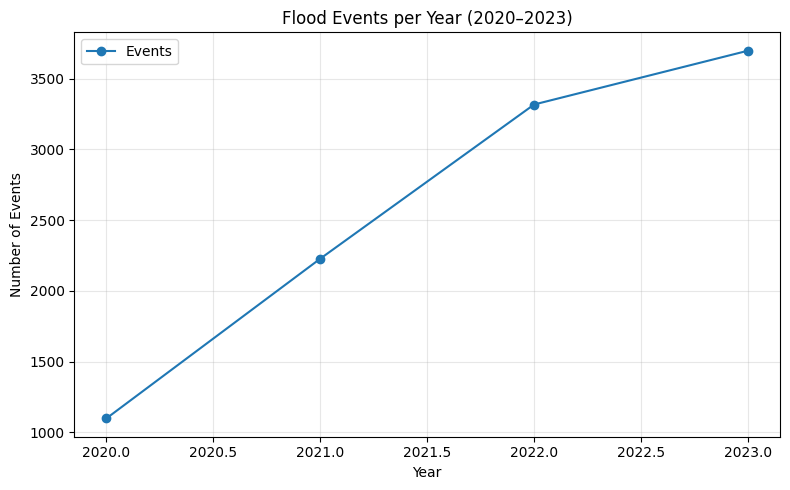

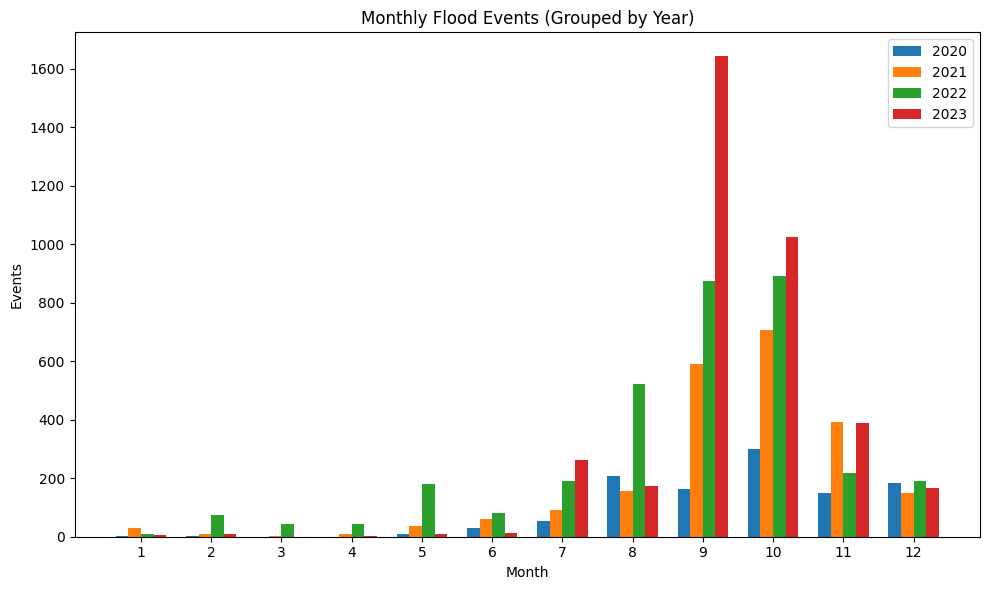

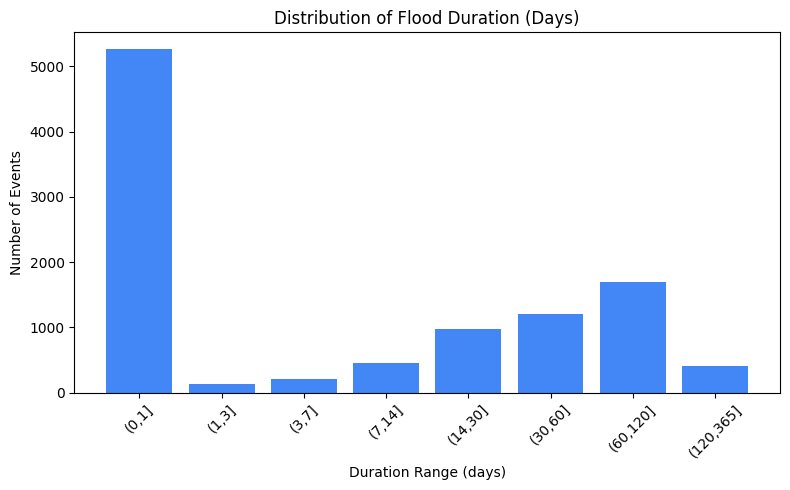

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== YEARLY TREND ==========
yearly_data = pd.DataFrame({
    "year": [2020, 2021, 2022, 2023],
    "events": [1100, 2228, 3317, 3697],
    "duration_mean": [19.66, 17.89, 18.06, 47.00]
})

plt.figure(figsize=(8,5))
plt.plot(yearly_data["year"], yearly_data["events"], marker="o", label="Events")
plt.title("Flood Events per Year (2020–2023)")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("yearly_flood_events.png", dpi=300)
plt.show()

# ========== MONTHLY SEASONALITY ==========
monthly_pivot = pd.DataFrame({
    2020:[1,3,0,0,8,31,53,208,164,299,148,185],
    2021:[30,9,1,8,37,59,93,155,589,706,393,148],
    2022:[9,75,42,43,179,81,191,522,875,891,219,190],
    2023:[6,8,0,4,9,13,263,174,1642,1025,388,165],
}, index=pd.Index(range(1,13), name="month"))

plt.figure(figsize=(10,6))
x = np.arange(1,13)
years = monthly_pivot.columns
width = 0.18

for i, y in enumerate(years):
    plt.bar(x + (i - (len(years)-1)/2)*width, monthly_pivot[y], width=width, label=str(y))

plt.title("Monthly Flood Events (Grouped by Year)")
plt.xlabel("Month")
plt.ylabel("Events")
plt.xticks(x, [str(m) for m in range(1,13)])
plt.legend()
plt.tight_layout()
plt.savefig("monthly_flood_events.png", dpi=300)
plt.show()

# ========== DURATION HISTOGRAM ==========
duration_bins = ["(0,1]", "(1,3]", "(3,7]", "(7,14]", "(14,30]", "(30,60]", "(60,120]", "(120,365]"]
duration_counts = [5259, 139, 207, 462, 977, 1199, 1695, 401]

dur_df = pd.DataFrame({"bin": duration_bins, "count": duration_counts})

plt.figure(figsize=(8,5))
plt.bar(dur_df["bin"], dur_df["count"], color="#4287f5")
plt.title("Distribution of Flood Duration (Days)")
plt.xlabel("Duration Range (days)")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("duration_distribution.png", dpi=300)
plt.show()

Matplotlib is building the font cache; this may take a moment.


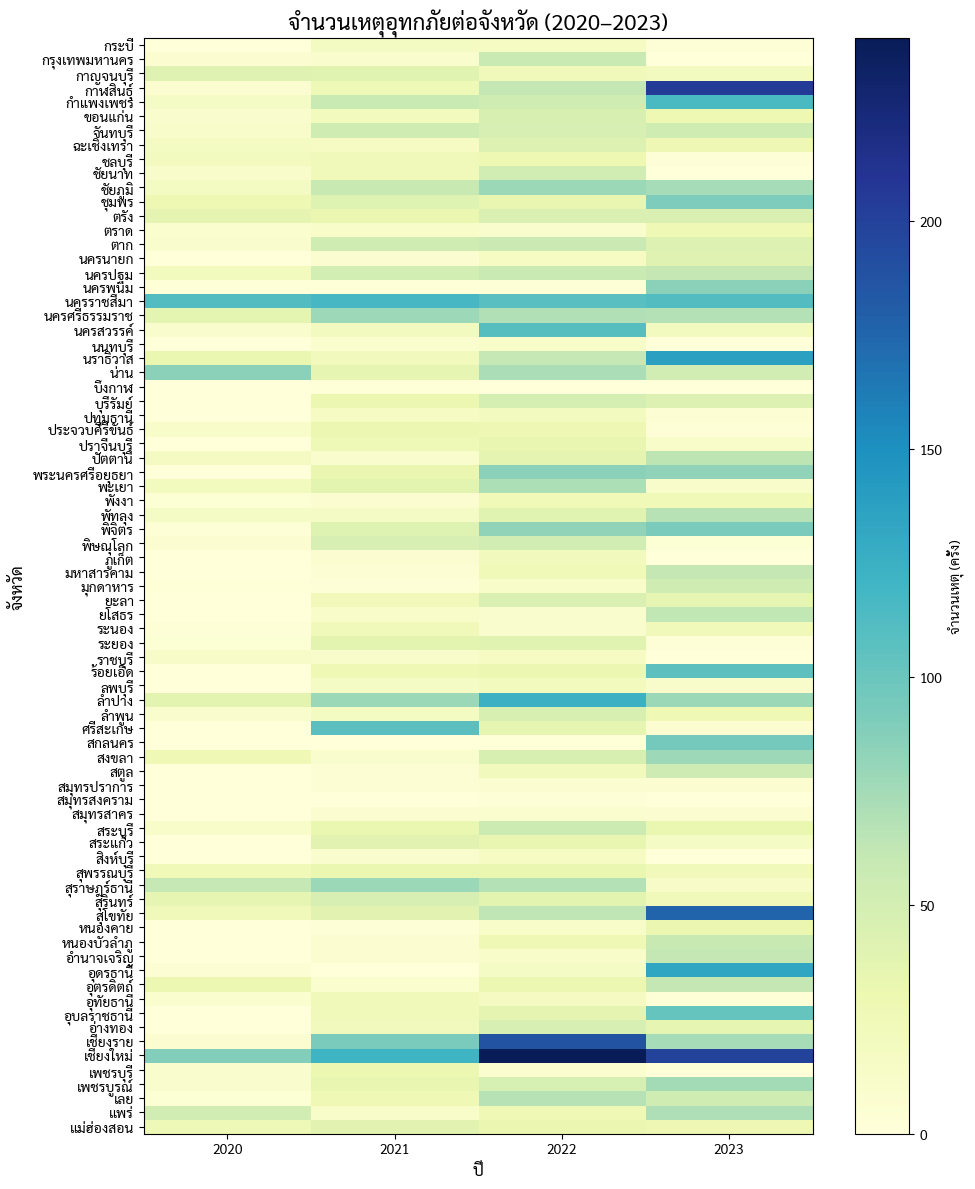

In [35]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# ติดตั้งฟอนต์ (เฉพาะครั้งแรก ถ้าไม่มี)
# !apt-get install fonts-thai-tlwg -y  # สำหรับ Colab
# หรือดาวน์โหลดฟอนต์ .ttf แล้วใส่ path เช่น "/usr/share/fonts/truetype/sarabun.ttf"

# ใช้ฟอนต์ Sarabun หรือ Noto Sans Thai ถ้ามี
font_candidates = ["Sarabun", "Noto Sans Thai", "Kanit", "Tahoma"]
for f in font_candidates:
    if f in [x.name for x in font_manager.fontManager.ttflist]:
        rcParams["font.family"] = f
        break
rcParams["axes.unicode_minus"] = False  # ให้แสดงเครื่องหมายลบได้

# ======================== DATA ========================
df1 = all_df[(all_df["disaster_date"].dt.year.between(2020, 2023))].copy()

prov_year = (
    df1.groupby([df1["disaster_date"].dt.year.rename("year"), "province"])
    .agg(events=("incident_id", "nunique"))
    .reset_index()
)

pivot = prov_year.pivot(index="province", columns="year", values="events").fillna(0)

# ======================== PLOT ========================
plt.figure(figsize=(10, 12))
im = plt.imshow(pivot.values, aspect="auto", cmap="YlGnBu")

plt.title("จำนวนเหตุอุทกภัยต่อจังหวัด (2020–2023)", fontsize=16, fontweight="bold")
plt.xlabel("ปี", fontsize=12)
plt.ylabel("จังหวัด", fontsize=12)

plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.colorbar(im, label="จำนวนเหตุ (ครั้ง)")

plt.tight_layout()
plt.savefig("heatmap_province_year.png", dpi=300)
plt.show()

In [26]:
pcts = (df1.assign(year=df1["disaster_date"].dt.year)
          .groupby("year")["duration_days"]
          .quantile([0.5,0.75,0.9]).unstack())
print(pcts)  # median/75th/90th percentile ต่อปี

      0.50   0.75   0.90
year                    
2020   1.0  32.00   64.0
2021   1.0  17.25   71.0
2022   1.0  14.00   72.0
2023  34.0  78.00  115.0


In [27]:
top_sub = (df1.groupby(["province","district","subdistrict"])
             .agg(events=("incident_id","nunique"),
                  years=("year", lambda s: pd.Series(s).nunique()),
                  mean_duration=("duration_days","mean"))
             .reset_index()
             .sort_values(["events","mean_duration"], ascending=[False,False]).head(50))
top_sub.to_csv("hotspots_subdistrict.csv", index=False)

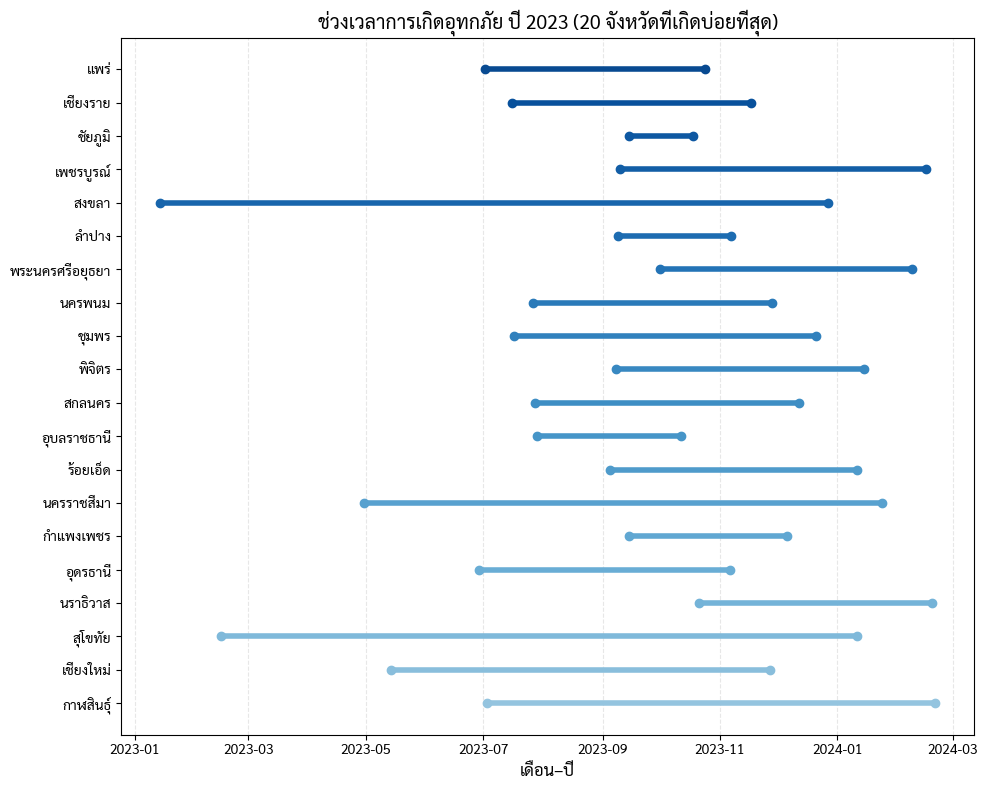

In [36]:
import pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
from matplotlib import font_manager, rcParams

# ตั้งค่าฟอนต์ไทย (เลือกตัวที่มีในระบบ)
for f in ["Sarabun", "Noto Sans Thai", "Kanit", "Tahoma"]:
    if f in [x.name for x in font_manager.fontManager.ttflist]:
        rcParams["font.family"] = f
        break
rcParams["axes.unicode_minus"] = False

# ======================== เตรียมข้อมูล ========================
df23 = df1[df1["disaster_date"].dt.year == 2023].copy()
df23["end"] = df23["end_disaster_date"].fillna(df23["disaster_date"])

pv = (
    df23.groupby("province")
    .agg(
        first=("disaster_date", "min"),
        last=("end", "max"),
        events=("incident_id", "nunique"),
    )
    .reset_index()
    .sort_values("events", ascending=False)
    .head(20)
)

# ======================== วาดกราฟ Timeline ========================
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(pv)))

for i, (idx, r) in enumerate(pv.iterrows()):
    ax.hlines(y=i, xmin=r["first"], xmax=r["last"], colors=colors[i], lw=4)
    ax.plot(r["first"], i, "o", color=colors[i], markersize=6)
    ax.plot(r["last"], i, "o", color=colors[i], markersize=6)

ax.set_yticks(range(len(pv)))
ax.set_yticklabels(pv["province"], fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_xlabel("เดือน–ปี", fontsize=12)
ax.set_title("ช่วงเวลาการเกิดอุทกภัย ปี 2023 (20 จังหวัดที่เกิดบ่อยที่สุด)", fontsize=14, fontweight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("timeline_2023_top20.png", dpi=300)
plt.show()

In [29]:
# นิยามตอนแบบง่าย: province+district+cause ใกล้กัน (ห่าง ≤ 3 วัน)
dfE = df1.copy()
dfE["end"] = dfE["end_disaster_date"].fillna(dfE["disaster_date"])
dfE["key"] = dfE[["province","district","cause"]].astype(str).agg("|".join, axis=1)

episodes = []
for g, gdf in dfE.groupby("key"):
    gdf = gdf.sort_values("disaster_date")
    cur_start, cur_end = None, None
    for _, row in gdf.iterrows():
        s, e = row["disaster_date"], row["end"]
        if cur_start is None:
            cur_start, cur_end = s, e
        elif (s - cur_end).days <= 3:
            cur_end = max(cur_end, e)
        else:
            episodes.append((g, cur_start, cur_end))
            cur_start, cur_end = s, e
    if cur_start is not None:
        episodes.append((g, cur_start, cur_end))

ep = pd.DataFrame(episodes, columns=["key","start","end"])
ep["episode_days"] = (ep["end"] - ep["start"]).dt.days + 1
ep = ep.join(dfE.drop_duplicates("key")[["key","province","district","cause"]].set_index("key"),
             on="key")
ep.to_csv("episodes_simple.csv", index=False)

In [30]:
df_lag = df1.copy()
df_lag["relief_declared_date"] = pd.to_datetime(df_lag.get("relief_declared_date"), errors="coerce")
df_lag["lag_days"] = (df_lag["relief_declared_date"] - df_lag["disaster_date"]).dt.days
by_year_lag = df_lag.groupby(df_lag["disaster_date"].dt.year)["lag_days"].median()
print(by_year_lag)  # median lag per year

disaster_date
2020     0.0
2021     0.0
2022     0.0
2023    11.0
Name: lag_days, dtype: float64


In [31]:
monthly = (df1.assign(ym=df1["disaster_date"].dt.to_period("M").astype(str))
             .groupby("ym")["incident_id"].nunique().reset_index())
monthly["t"] = range(len(monthly))
# สัญญาณหยาบ: สไลด์ค่าเฉลี่ย 6 เดือนเปรียบเทียบก่อน/หลัง
k=6
monthly["ma"] = monthly["incident_id"].rolling(k, min_periods=1).mean()
print(monthly.tail(12))

         ym  incident_id   t          ma
33  2022-12          190  33  481.333333
34  2023-01            6  34  450.500000
35  2023-02            8  35  364.833333
36  2023-04            4  36  219.666667
37  2023-05            9  37   72.666667
38  2023-06           13  38   38.333333
39  2023-07          263  39   50.500000
40  2023-08          174  40   78.500000
41  2023-09         1642  41  350.833333
42  2023-10         1025  42  521.000000
43  2023-11          388  43  584.166667
44  2023-12          165  44  609.500000


In [32]:
prov_total = (df1.groupby("province")["incident_id"].nunique()
                .sort_values(ascending=False).reset_index(name="events"))
prov_total["cum_events"] = prov_total["events"].cumsum()
prov_total["cum_share"] = prov_total["cum_events"]/prov_total["events"].sum()
prov_total["prov_share"] = (np.arange(1, len(prov_total)+1))/len(prov_total)
prov_total.to_csv("lorenz_province.csv", index=False)
# จุดที่ prov_share ~0.2 คือ 20% จังหวัดแรก → cum_share คือสัดส่วนเหตุ

In [33]:
d23 = df1[df1["disaster_date"].dt.year==2023].copy()
daily = d23.groupby(d23["disaster_date"].dt.date)["incident_id"].nunique().reset_index(name="events")
print(daily.head())  # ใช้ทำปฏิทิน/เส้นรายวันต่อได้

  disaster_date  events
0    2023-01-09       1
1    2023-01-11       1
2    2023-01-14       1
3    2023-01-17       1
4    2023-01-25       1


In [34]:
qa = {}
qa["end_date_nonnull_ratio"] = df1["end_disaster_date"].notna().mean()
qa["duration_gt_180d"] = int((df1["duration_days"]>180).sum())
qa["duration_eq_1d_ratio"] = (df1["duration_days"]==1).mean()
print(qa)

{'end_date_nonnull_ratio': np.float64(0.6643140288117567), 'duration_gt_180d': 9, 'duration_eq_1d_ratio': np.float64(0.5084598279029295)}
